# Interactions between ProTα and Histone H1.0 evolution variants

In [1]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Topologies

#### Compact frames

In [4]:
# Loading trajectories
trajs = {}
resultsdir = "results/single_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    trajs[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

In [7]:
# Saving most compact frame as topology
for variant, traj in trajs.items():
    compact_frame = analyse_utils.compact_frame(traj)
    compact_frame.save_pdb(f'data/{variant}.pdb')

#### Merging

In [2]:
# Loading topologies
H10_vars = {}
ProTa = None
data_path = 'data'
for file in os.listdir(data_path):
    if '.pdb' in file:
        traj = md.load(f'{data_path}/{file}')

        id = file[:-4]
        if ('H1-0_VAR' in id) and ('PROTA_WT' not in id):
            H10_vars[id] = traj

        elif 'PROTA_WT' == id:
            ProTa = traj

print(H10_vars.keys())

dict_keys(['H1-0_VAR_k0.21', 'H1-0_VAR_k0.80', 'H1-0_VAR_k0.14', 'H1-0_VAR_k0.36', 'H1-0_VAR_k0.46', 'H1-0_VAR_k0.18', 'H1-0_VAR_k0.30', 'H1-0_VAR_k0.89', 'H1-0_VAR_k0.70', 'H1-0_VAR_k0.92', 'H1-0_VAR_k0.85', 'H1-0_VAR_k0.27', 'H1-0_VAR_k0.75', 'H1-0_VAR_k0.60', 'H1-0_VAR_k0.65', 'H1-0_VAR_k0.55', 'H1-0_VAR_k0.50', 'H1-0_VAR_k0.40', 'H1-0_VAR_k0.07', 'H1-0_VAR_k0.11'])


In [3]:
# Making sets of topologies
twochain_sets = [[H10_var, ProTa] for H10_var in H10_vars.values()]

In [4]:
# Translating topologies
for tc_set  in twochain_sets:
    translate_x = 10 # nm
    translate_y = 0 # nm
    translate_z = 0 # nm
    for i, traj in enumerate(tc_set):
        traj.center_coordinates()
        traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [5]:
# Merging topologies
boxlength = 25 # nm
tc_merges = [simulate_utils.merge_topologies(tc_set, boxlength=boxlength) for tc_set in twochain_sets]
for traj in tc_merges:
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2

In [6]:
# Saving merged topologies
for traj, H10_var_id in zip(tc_merges, H10_vars.keys()):
    filename = f'data/{H10_var_id}_PROTA_WT_{boxlength}nm.pdb'
    traj.save(filename)

## Analysis

### Single chain

In [220]:
# Loading trajectories
traj = {}
resultsdir = "results/single_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    traj[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

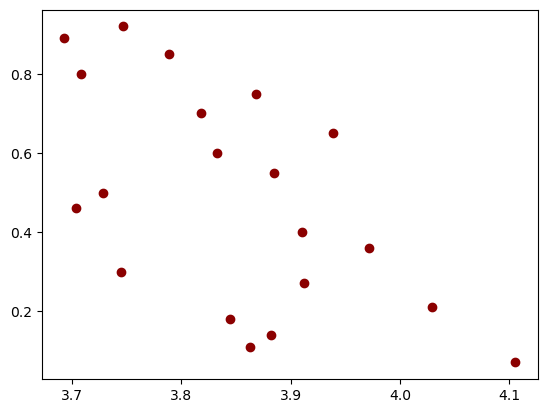

In [221]:
# Checking Rg kappa range
kappas = [float(var[-4:]) for var in traj]
rgs = [analyse_utils.compute_rg(t) for t in traj.values()]
mean_rgs = [rg.mean() for rg in rgs]
data = pd.DataFrame({'kappa': kappas, 'Rg': rgs, '<Rg>': mean_rgs}, index=traj.keys())

plt.scatter(data['<Rg>'], data['kappa'], color='darkred')

In [225]:
data[['kappa', '<Rg>']].sort_values('kappa')

,kappa,<Rg>
H1-0_VAR_k0.07,0.07,4.105653
H1-0_VAR_k0.11,0.11,3.862372
H1-0_VAR_k0.14,0.14,3.882315
H1-0_VAR_k0.18,0.18,3.844527
H1-0_VAR_k0.21,0.21,4.029222
H1-0_VAR_k0.27,0.27,3.912604
H1-0_VAR_k0.30,0.30,3.744918
H1-0_VAR_k0.36,0.36,3.971769
H1-0_VAR_k0.40,0.40,3.910393
H1-0_VAR_k0.46,0.46,3.703828


### Two chain

In [2]:
# Loading trajectories
traj = {}
residues = {}
resultsdir = "results/two_chain/ionic_240"
for variant in sorted(os.listdir(resultsdir)):
    dir = f"{resultsdir}/{variant}"
    traj[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")
    residues[variant] = simulate_utils.extract_sequences(traj[variant].top)

#### Distances

20it [19:54, 59.70s/it]


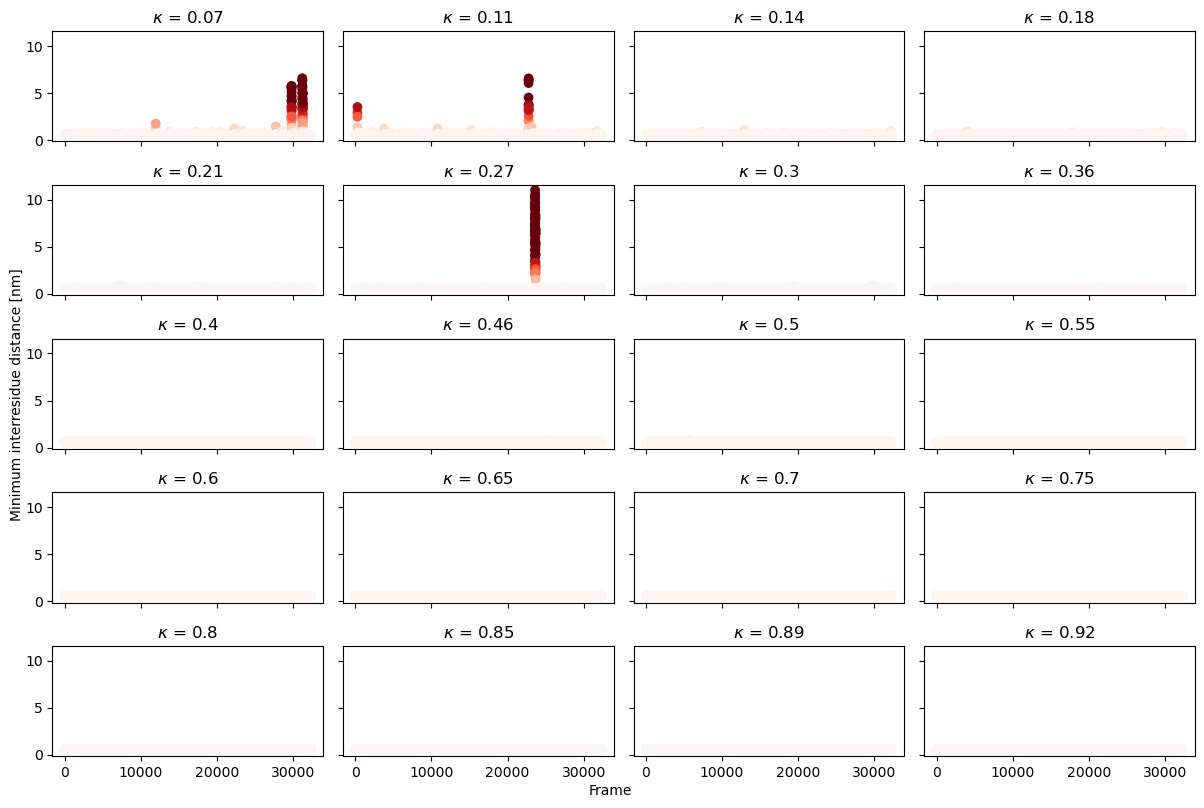

In [219]:
# Finding separation events
from matplotlib import colormaps
from tqdm import tqdm

fig, axes = plt.subplots(5,4,figsize=(12,8), sharex=True, sharey=True)
for i, variant in tqdm(enumerate(sorted(traj))):
    ax = axes.flatten()[i]

    # Finding interchain pairs
    var_traj = traj[variant]
    inter_pairs = var_traj.top.select_pairs('chainid 0', 'chainid 1')

    # Calculating interresidue distances
    dist = md.geometry.squareform(md.compute_distances(var_traj, inter_pairs), inter_pairs)

    # Selecting interresidue distances in distance matrix
    dist_inter = dist[:, np.unique(inter_pairs[:,0]), :][:, :, np.unique(inter_pairs[:,1])]

    # Finding minimum interresidue distance in each frame
    min_dist_inter = dist_inter.min(axis=(1,2))

    # Plotting
    cmap = colormaps['Reds']
    norm = plt.Normalize(0,4)
    ax.scatter(range(len(min_dist_inter)), min_dist_inter, color=cmap(norm(min_dist_inter)))
    kappa = float(variant[10:14])
    ax.set_title(f"$\kappa$ = {kappa}")

fig.text(0.5, 0, 'Frame', ha='center')
fig.text(0, 0.5, 'Minimum interresidue distance [nm]', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

In [233]:
r = simulate_utils.extract_sequences(var_traj.top)

0it [00:00, ?it/s]/tmp/ipykernel_9622/4066413067.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.imshow(mean_dist_inter, vmin=0, vmax=4, cmap=plt.cm.get_cmap('Reds_r'))
20it [00:01, 13.81it/s]


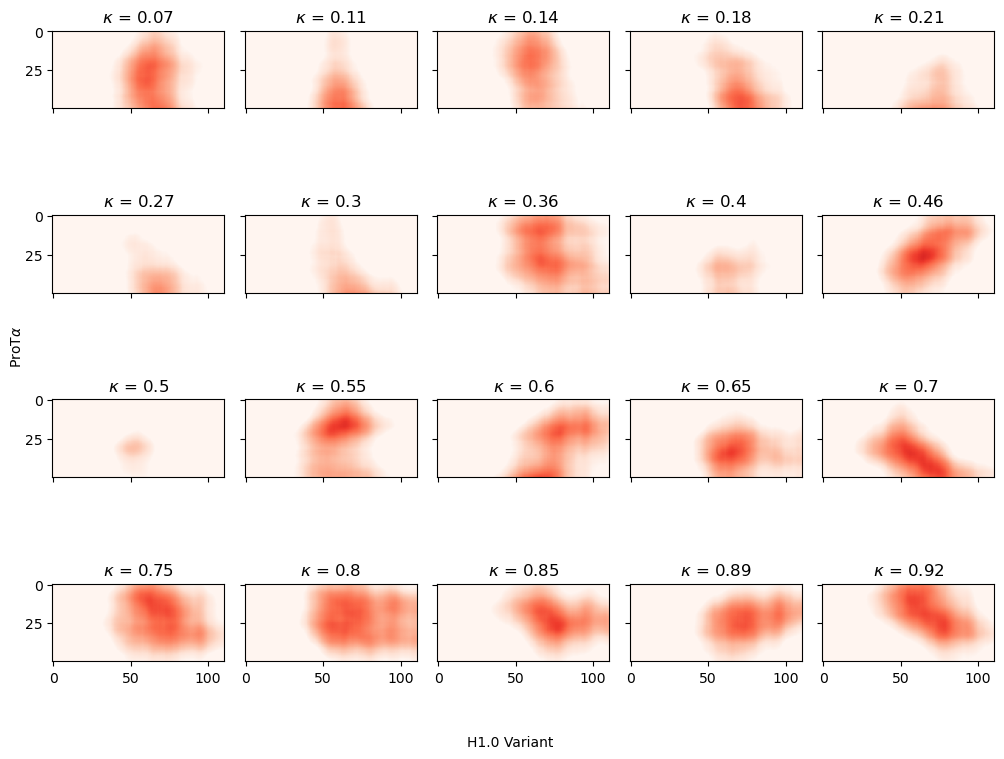

In [236]:
# Finding distances
from tqdm import tqdm

fig, axes = plt.subplots(4,5,figsize=(10,8), sharex=True, sharey=True)
for i, variant in tqdm(enumerate(sorted(traj))):
    ax = axes.flatten()[i]

    # Finding interchain pairs
    var_traj = traj[variant][:100]
    inter_pairs = var_traj.top.select_pairs('chainid 0', 'chainid 1')

    # Calculating interresidue distances
    dist = md.geometry.squareform(md.compute_distances(var_traj, inter_pairs), inter_pairs)

    # Selecting interresidue distances in distance matrix
    dist_inter = dist[:, np.unique(inter_pairs[:,0]), :][:, :, np.unique(inter_pairs[:,1])]

    # Finding mean interresidue distance
    mean_dist_inter = dist_inter.mean(axis=0)

    # Plotting
    ax.imshow(mean_dist_inter, vmin=0, vmax=4, cmap=plt.cm.get_cmap('Reds_r'))
    kappa = float(variant[10:14])
    ax.set_title(f"$\kappa$ = {kappa}")

fig.text(0.5, 0, 'ProT$\\alpha$', ha='center')
fig.text(0, 0.5, 'H1.0 Variant', va='center', rotation='vertical')
#plt.colorbar(label="Distance [nm]")
plt.tight_layout()
plt.show()

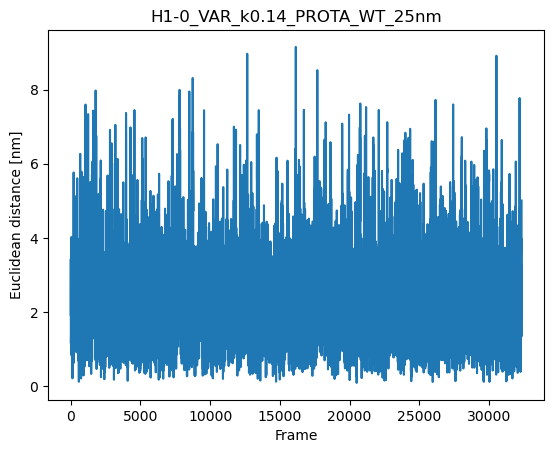

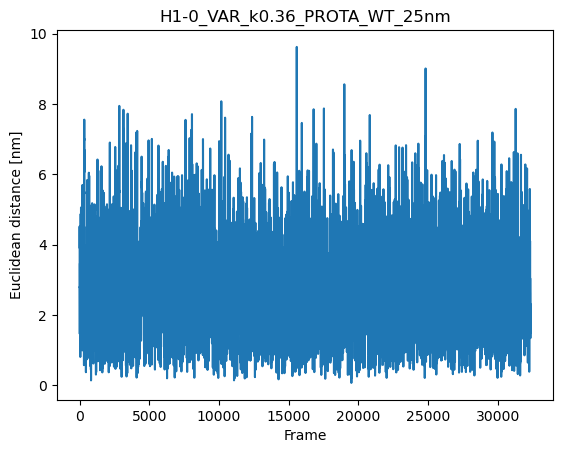

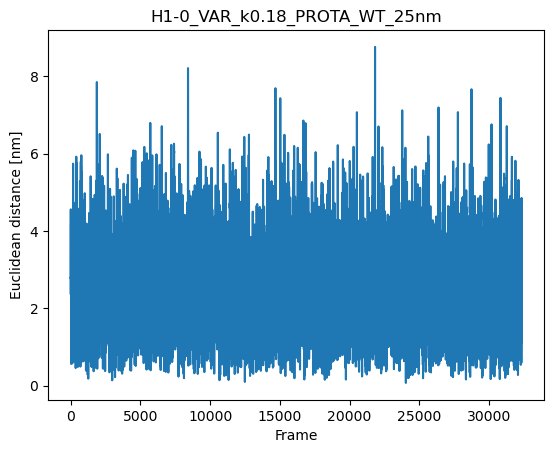

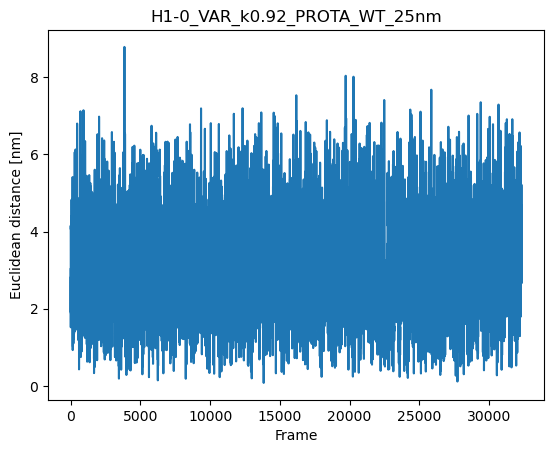

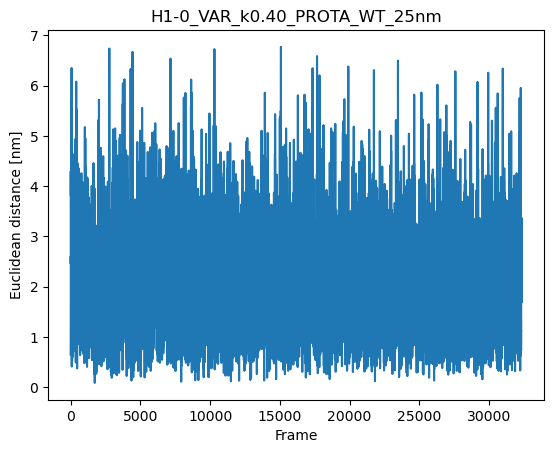

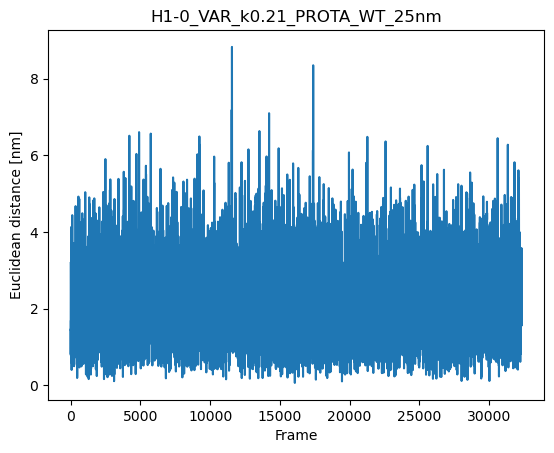

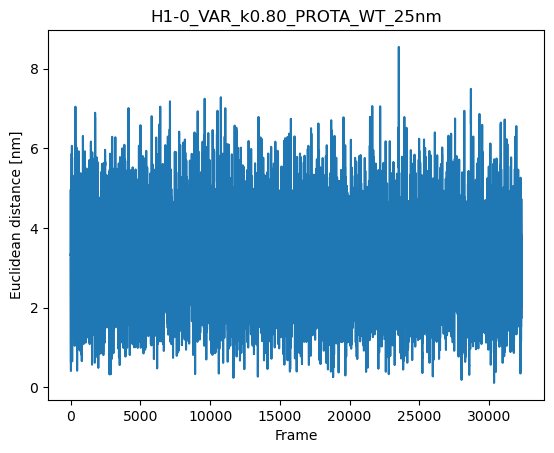

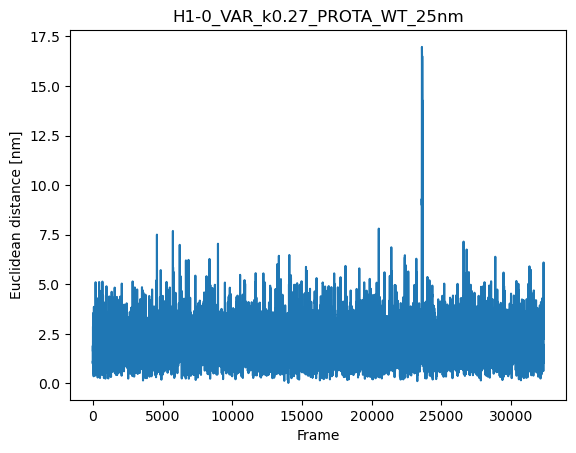

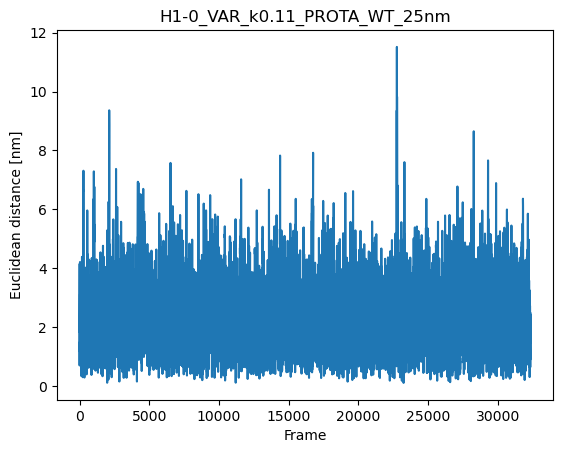

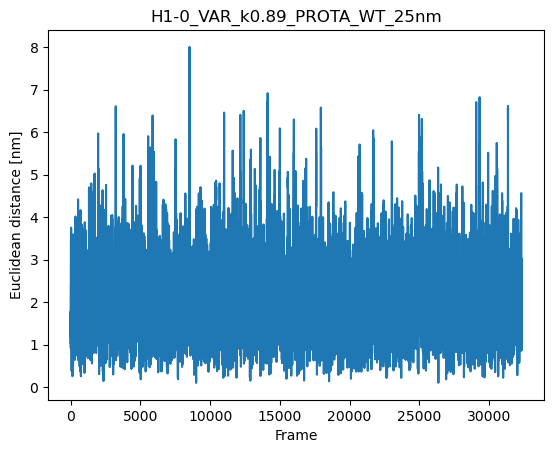

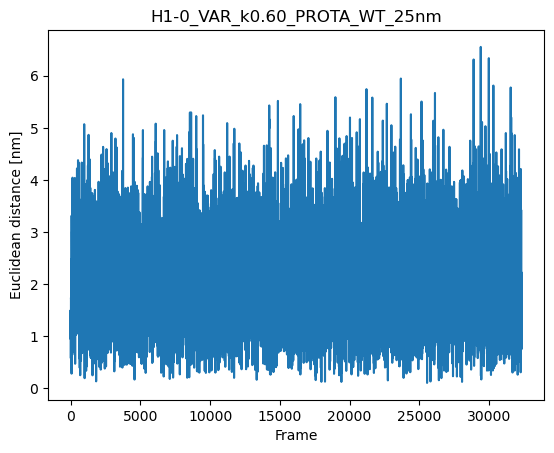

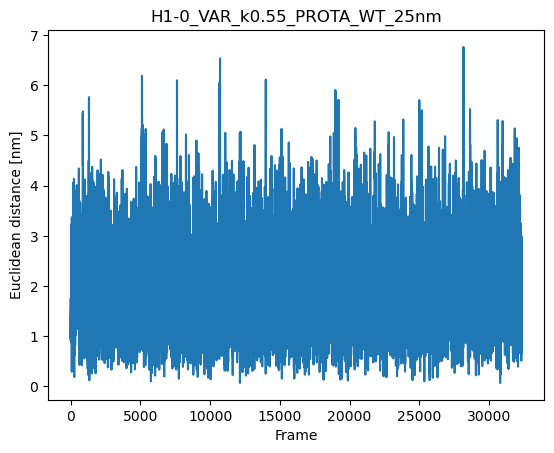

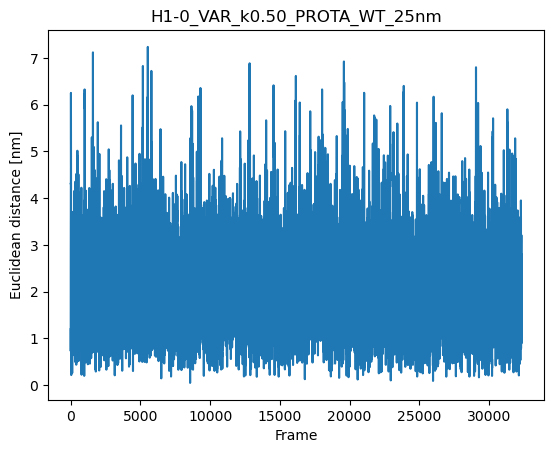

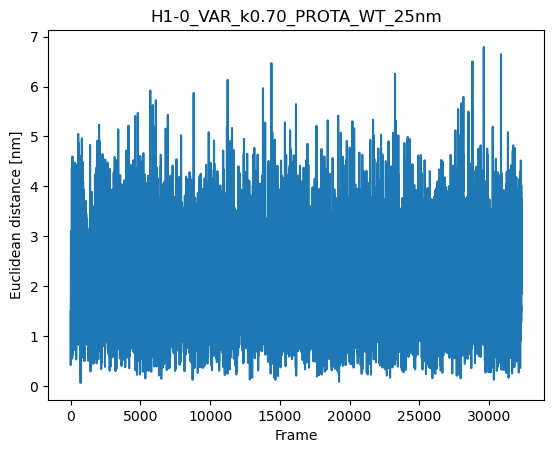

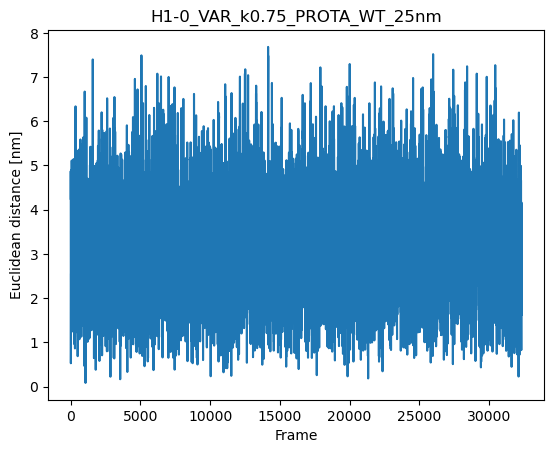

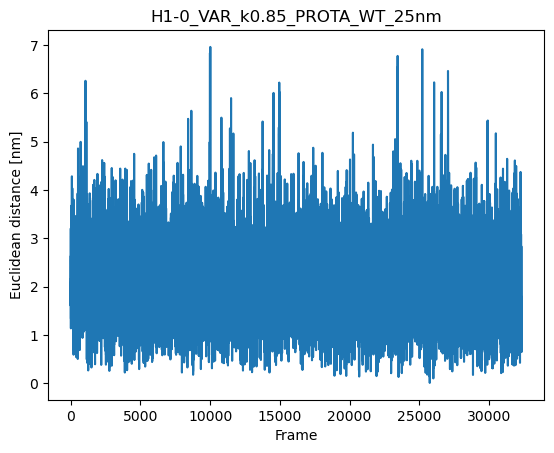

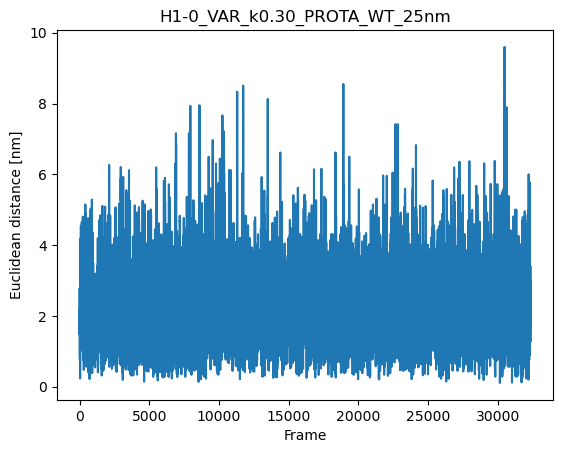

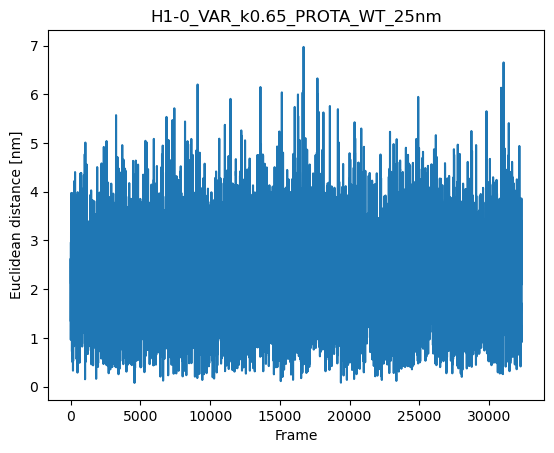

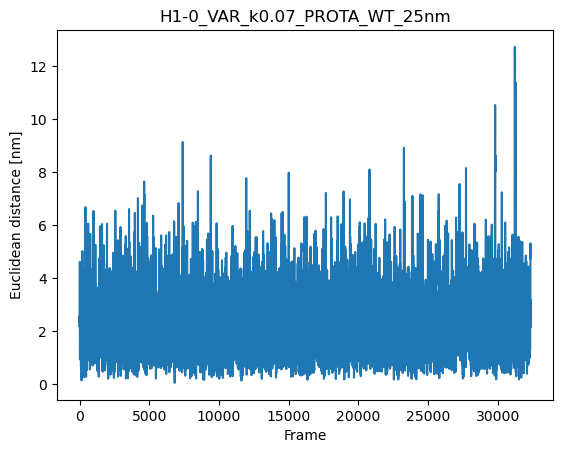

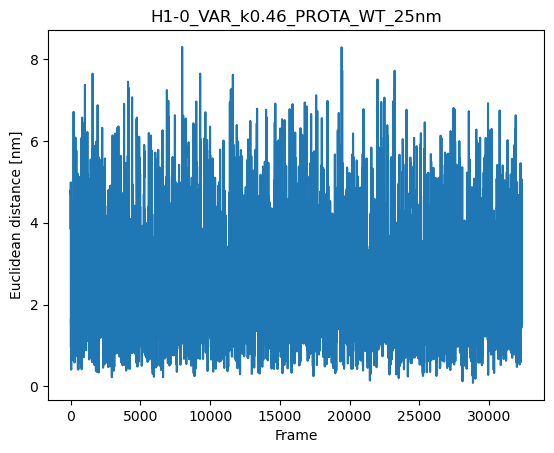

In [9]:
# Computing center of mass c
for variant in traj:
    com_H10 = analyse_utils.compute_com(traj[variant].atom_slice(residues[variant].res[residues[variant].chain == 0]))
    com_ProTa = analyse_utils.compute_com(traj[variant].atom_slice(residues[variant].res[residues[variant].chain == 1]))
    com_diff = (((com_H10-com_ProTa)**2).sum(axis=1))**0.5
    plt.plot(com_diff)
    plt.title(variant)
    plt.xlabel("Frame")
    plt.ylabel("Euclidean distance [nm]")
    plt.show()

#### $K_d$

In [15]:
!scp "fend01:~/OrthoIDP/exp/prota_variant/results/two_chain/ionic_240/H1-0_VAR_k0.21_PROTA_WT_25nm/interaction_energy.csv" "results/two_chain/ionic_240/H1-0_VAR_k0.21_PROTA_WT_25nm/interaction_energy.csv"

interaction_energy.csv                        100%   49MB   6.9MB/s   00:07    


In [99]:
# Loading precomputed energies
datas = {}
resultsdir = "results/two_chain/ionic_240"
for variant in sorted(os.listdir(resultsdir)):
    file = f"{resultsdir}/{variant}/interaction_energy.csv"
    try:
        datas[variant] = pd.read_csv(file)
        datas[variant]['Total energy [kJ/mol]'] = datas[variant]['Ashbaugh-Hatch [kJ/mol]'] + datas[variant]['Debye-Hückel [kJ/mol]']
    except:
        continue
datas.keys()

dict_keys(['H1-0_VAR_k0.07_PROTA_WT_25nm', 'H1-0_VAR_k0.21_PROTA_WT_25nm', 'H1-0_VAR_k0.40_PROTA_WT_25nm', 'H1-0_VAR_k0.50_PROTA_WT_25nm', 'H1-0_VAR_k0.60_PROTA_WT_25nm', 'H1-0_VAR_k0.85_PROTA_WT_25nm'])

In [100]:
data = datas['H1-0_VAR_k0.07_PROTA_WT_25nm']
data

,Unnamed: 0,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol]
0,0,-2.948417,-15.006933,0.579106,6.226366,-17.955350
1,1,-4.149840,-14.869695,0.549029,6.536238,-19.019534
2,2,-3.468208,-24.881678,0.587783,5.545913,-28.349886
3,3,-3.222524,-18.576228,0.590223,4.723788,-21.798751
4,4,0.887686,-32.274902,0.514596,4.444585,-31.387216
...,...,...,...,...,...,...
30995,30995,-1.919477,-33.124373,0.534768,3.266718,-35.043850
30996,30996,3.793240,-24.797814,0.551512,4.329354,-21.004574
30997,30997,-0.062181,-29.427375,0.570540,4.856690,-29.489556
30998,30998,-6.446331,-37.427947,0.564629,4.369197,-43.874277


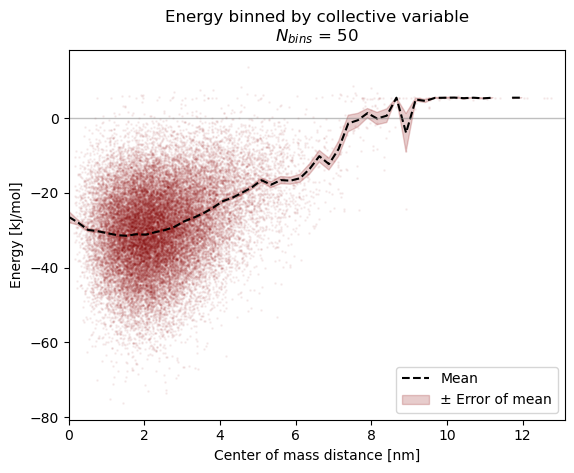

5.355893437868861

In [102]:
analyse_utils.compute_Kd(data['Total energy [kJ/mol]'], data['Center of mass distance [nm]'], 298, 50)